## Practice 1: Linear Regression <br>
<br>
<br>

1. Read data, analyze it, split it into train and test set using scikit-learn train_test_split. Read about why we do this.
[why split the data](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/) <br>
2. Implement your own linear regression. (numpy or torch)<br>
3. Try calculating it using <b>Normal equation</b> VS <b>Gradient descent</b>. Try implementing it using only the formulas. Which one is faster? In which situation is gradient descent faster than normal equation?<br>
4. Compare performance to scikit-learn LinearRegression. <br>
5. Try adding in L1 or L2 regularization. Try different regularization weights. Does it help? Read about regularization and why we do it. [regularization](https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a) <br>
6. Try scaling your data using scikit learn StandardScaler or other techniques [data scaling](https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/)

Might find useful [hands on ML](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

In [1]:
import pandas as pd
import numpy as np
import torch

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(42)
torch.manual_seed(42)
sns.set(palette = 'Set2', style='whitegrid')

In [3]:
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

#### Housing dataset
[dataset description](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)

In [4]:
data = datasets.load_boston()

In [5]:
X = data['data']
y = data['target']
print(f"Feature list: {data['feature_names']}")
print(data['DESCR'])

Feature list: ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

## scikit-learn

In [7]:
%%time 
model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'train loss: {mean_squared_error(y_train, y_train_pred)}')
print(f'test loss: {mean_squared_error(y_test, y_test_pred)}')

train loss: 21.641412753226312
test loss: 24.291119474973456
CPU times: user 15 ms, sys: 0 ns, total: 15 ms
Wall time: 3.66 ms


<BarContainer object of 14 artists>

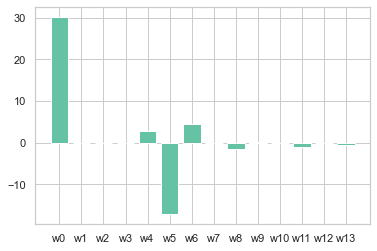

In [8]:
W = np.concatenate([[model.intercept_], model.coef_])

plt.bar([f'w{i}' for i in range(len(W))], W)

# Implementation

In [9]:
class MyLinearRegression:
    def __init__(
        self, method='equation', learning_rate=1e-6, lambda_l1=0, lambda_l2=0,
        max_iter = 200, verbose = 20
    ):
        self.mode = method
        self.lr = learning_rate
        self.lambda_l1, self.lambda_l2 = lambda_l1, lambda_l2
        self.max_iter = max_iter
        self.verbose = verbose
        
        valid_modes = ['equation', 'gradient']
        if self.mode not in valid_modes:
            print(f'wrong method: {self.mode}')
            raise NameError
        
    def calculate_loss(self, y, h):
        # calculate loss without regularization
        error = y-h
        J = torch.sum(error*error) / self.m #mse
        
        # calculate loss for l1 and l2 regularization
        J_l1 = self.lambda_l1 * torch.abs(self.theta).sum()
        J_l2 = 0.5 * self.lambda_l2 * (self.theta ** 2).sum()
        J += J_l1 + J_l2
        return J.item()
    
    def calculate_grad(self, X, y, h): 
        # calculate gradient without regularization
        error = y - h
        grad = -(2./ self.m) * torch.mm(X.t(), error)
        
        # calculate gradiet for l1 and l2 regularization
        grad_l1 = self.lambda_l1 * torch.sign(self.theta)
        grad_l2 = self.lambda_l2 * self.theta
        grad += grad_l1 + grad_l2
        return grad
    

    def fit(self, X_train, y_train):
        X = X_train
        y = y_train
        
        ones = torch.ones(X.size(0), 1).to(DEVICE) 
        X = torch.cat((ones, X), 1) # add constant to X
        y = y.view(-1, 1) # size[m] -> [m,1]
        
        self.m, self.n = X.size()
        
        if self.mode == 'gradient':
            # initial random weights
            self.theta=torch.randn((self.n,1)).to(DEVICE) # weights
            
            #initial predictions
            h = torch.mm(X , self.theta).to(DEVICE)

            for i in range(self.max_iter):
                # calculate loss
                J = self.calculate_loss(y,h)
                
                # gradiant descent
                grad = self.calculate_grad(X,y,h)
                self.theta -= self.lr * grad
                
                # predict with updated weights
                h = torch.mm(X , self.theta)
                
                if i==0 or (i+1)%self.verbose==0 or i==self.max_iter-1:
                    print(f'[{i+1:07d}/{self.max_iter:07d}] loss {J:.3f}')
                
        elif self.mode == 'equation':
            # Ridge
            I = torch.eye(self.n).to(DEVICE)
            
            # theta = ((X.T @ X) + alpha * I)^(-1) @ X.T @ y
            self.theta = torch.mm(torch.mm(
                torch.inverse(torch.mm(X.t(), X) + self.lambda_l2 * I),
                X.t()), y)
    
    def predict(self, X_test):
        X = X_test
        ones = torch.ones(X.size(0), 1).to(DEVICE)
        X = torch.cat((ones, X), 1)
        return torch.mm(X, self.theta).view(-1).cpu().data.numpy()

In [10]:
X_train = torch.from_numpy(X_train).float().to(DEVICE)
X_test = torch.from_numpy(X_test).float().to(DEVICE)
y_train = torch.from_numpy(y_train).float().to(DEVICE)
y_test = torch.from_numpy(y_test).float().to(DEVICE)

In [11]:
def fit_eval_model(params, X_train, X_test, y_train, y_test, loss = mean_squared_error):
    
    model = MyLinearRegression(**params)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print(f'train loss: {loss(y_train.cpu().data.numpy(), y_train_pred)}')
    print(f'test loss: {loss(y_test.cpu().data.numpy(), y_test_pred)}')
    
    W = model.theta.view(-1).cpu().data.numpy()
    plt.bar([f'w{i}' for i in range(len(W))], W)
    plt.show()
    plt.close()
    
    return model

## Normal equation

train loss: 21.64141273498535
test loss: 24.2912540435791


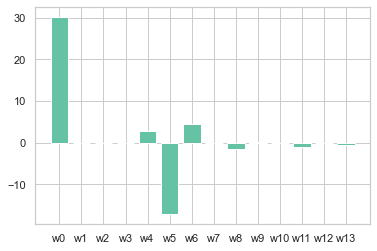

CPU times: user 306 ms, sys: 48.9 ms, total: 355 ms
Wall time: 354 ms


In [12]:
%%time 
params = dict(method = 'equation')
model_normal = fit_eval_model(params, X_train, X_test, y_train, y_test)

## Normal equation with l2 regularization

train loss: 22.32554817199707
test loss: 26.606237411499023


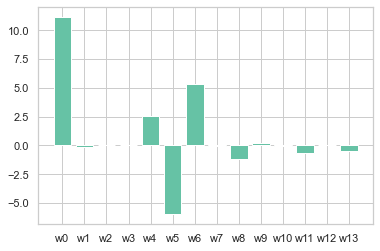

CPU times: user 129 ms, sys: 4.88 ms, total: 134 ms
Wall time: 132 ms


In [13]:
%%time 

params = dict(method = 'equation', lambda_l2 = 1)
model_normal = fit_eval_model(params, X_train, X_test, y_train, y_test)

## Gradient without regularization

[0000001/0100000] loss 327278.938
[0010000/0100000] loss 46.022
[0020000/0100000] loss 41.040
[0030000/0100000] loss 38.658
[0040000/0100000] loss 37.277
[0050000/0100000] loss 36.351
[0060000/0100000] loss 35.666
[0070000/0100000] loss 35.124
[0080000/0100000] loss 34.673
[0090000/0100000] loss 34.285
[0100000/0100000] loss 33.943
train loss: 33.94306182861328
test loss: 34.49124526977539


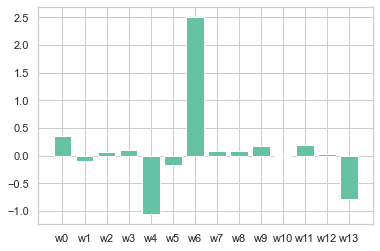

CPU times: user 22.2 s, sys: 75.6 ms, total: 22.3 s
Wall time: 22.9 s


In [14]:
%%time 
params = dict(method = 'gradient', learning_rate=1e-6, verbose=10000, max_iter = 100000)
model_grad = fit_eval_model(params, X_train, X_test, y_train, y_test)

## Gradient with l2 regularization

[0000001/0100000] loss 136275.297
[0010000/0100000] loss 82.501
[0020000/0100000] loss 66.725
[0030000/0100000] loss 61.361
[0040000/0100000] loss 58.449
[0050000/0100000] loss 56.564
[0060000/0100000] loss 55.247
[0070000/0100000] loss 54.279
[0080000/0100000] loss 53.544
[0090000/0100000] loss 52.973
[0100000/0100000] loss 52.522
train loss: 42.86871337890625
test loss: 41.24161148071289


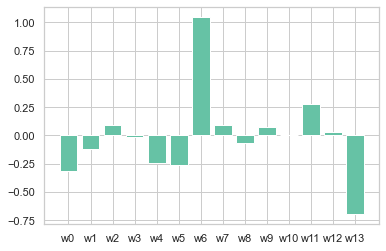

CPU times: user 22.2 s, sys: 121 ms, total: 22.3 s
Wall time: 22.3 s


In [15]:
%%time 

params = dict(method = 'gradient', learning_rate=1e-6, verbose=10000, max_iter = 100000, lambda_l2=10)
model_gradl2 = fit_eval_model(params, X_train, X_test, y_train, y_test)

## Gradient with l1 regularization

[0000001/0100000] loss 12387.679
[0010000/0100000] loss 109.096
[0020000/0100000] loss 90.236
[0030000/0100000] loss 80.723
[0040000/0100000] loss 74.579
[0050000/0100000] loss 70.393
[0060000/0100000] loss 69.075
[0070000/0100000] loss 67.877
[0080000/0100000] loss 66.758
[0090000/0100000] loss 65.692
[0100000/0100000] loss 65.575
train loss: 52.259708404541016
test loss: 48.880592346191406


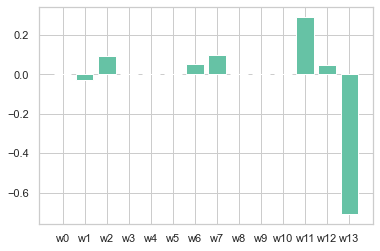

CPU times: user 22.9 s, sys: 160 ms, total: 23.1 s
Wall time: 23.1 s


In [16]:
%%time 

params = dict(method = 'gradient', learning_rate=1e-6, verbose=10000, max_iter = 100000, lambda_l1=10)
model_gradl1 = fit_eval_model(params, X_train, X_test, y_train, y_test)

## Gradient with standardization 

In [17]:
def standardize(mu, std, X):
    X -= mu.unsqueeze(0).expand(X.size())
    X /= std.unsqueeze(0).expand(X.size())
    return X


In [18]:
mu, std = X_train.mean(0), X_train.std(0)
mu

tensor([3.6091e+00, 1.1569e+01, 1.0985e+01, 7.1782e-02, 5.5648e-01, 6.3159e+00,
        6.8556e+01, 3.8082e+00, 9.3564e+00, 4.0403e+02, 1.8318e+01, 3.5628e+02,
        1.2457e+01], device='cuda:0')

In [19]:
X_train_std = standardize(mu, std, X_train)
X_test_std = standardize(mu, std, X_test)

[0000001/0001000] loss 686.310
[0000100/0001000] loss 441.729
[0000200/0001000] loss 300.241
[0000300/0001000] loss 208.316
[0000400/0001000] loss 147.292
[0000500/0001000] loss 106.581
[0000600/0001000] loss 79.349
[0000700/0001000] loss 61.093
[0000800/0001000] loss 48.825
[0000900/0001000] loss 40.561
[0001000/0001000] loss 34.977
train loss: 34.9316291809082
test loss: 38.32062911987305


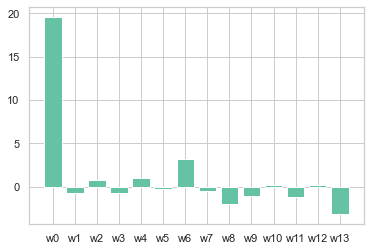

CPU times: user 382 ms, sys: 16.1 ms, total: 399 ms
Wall time: 396 ms


In [20]:
%%time 

params = dict(method = 'gradient', learning_rate=1e-3, verbose=100, max_iter = 1000)
model_std = fit_eval_model(params, 
                            X_train_std, X_test_std, y_train, y_test)

## Gradient with MinMax 

In [21]:
def minmax(min_x, max_x, X):
    X -= min_x.unsqueeze(0).expand(X.size())
    X /= (max_x - min_x).unsqueeze(0).expand(X.size())
    return X

In [22]:
min_x, max_x = X_train.min(0).values, X_train.max(0).values
min_x

tensor([-0.4056, -0.4997, -1.4859, -0.2777, -1.4569, -3.4574, -2.3453, -1.2568,
        -0.9728, -1.3061, -2.5658, -3.8874, -1.5087], device='cuda:0')

In [23]:
X_train_norm = minmax(min_x, max_x, X_train)
X_test_norm = minmax(min_x, max_x, X_test)

[0000001/0001000] loss 639.456
[0000100/0001000] loss 235.295
[0000200/0001000] loss 136.111
[0000300/0001000] loss 108.372
[0000400/0001000] loss 97.425
[0000500/0001000] loss 90.832
[0000600/0001000] loss 85.711
[0000700/0001000] loss 81.348
[0000800/0001000] loss 77.527
[0000900/0001000] loss 74.152
[0001000/0001000] loss 71.160
train loss: 71.13180541992188
test loss: 64.03260803222656


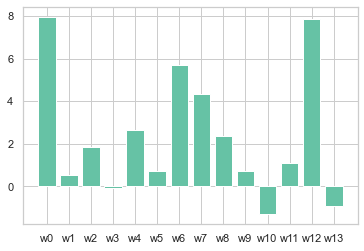

CPU times: user 359 ms, sys: 7.99 ms, total: 367 ms
Wall time: 366 ms


In [24]:
%%time 

params = dict(method = 'gradient', learning_rate=1e-3, verbose=100, max_iter = 1000)
model_norm = fit_eval_model(params, 
                            X_train_norm, X_test_norm, y_train, y_test)